## **Surrogate modelling to design a digital twin for ground source heat exchangers**

Author: Emilio Osuna

Data exploration is done in `data_exploration.ipynb`

In [42]:
import torch
import torch.nn as nn
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from src import heat_transfer_pinn

The purpose of this notebook is to perform the simulations of a surrogate model based on [Yildiz & Stirling, 2022](https://doi.org/10.1016/j.geothermics.2022.102351), where a finite difference model is used to predict soil temperature.

The governing PDE model is a transient heat conduction equation:

\begin{equation}
    \frac{\partial T}{\partial t} = \alpha \frac{\partial^2 T}{\partial z^2} + \frac{\partial \alpha}{\partial z} \frac{\partial T}{\partial z}
\end{equation}


The thermal diffusivity $\alpha$ changes over time and space. The upper temperature measured at the top of the lysimeter is consider as the boundary condition (Dirichlet). The heat flux at the lower boundary is calculated by adding the measured heat flux at 940 mm depth, and the energy stored in the soil layer between 850 mm and 940 mm:

\begin{equation}
    \Delta S = \int_{z=850}^{z=940} C \frac{\partial T}{\partial t} \, dz + \int_{z=850}^{z=940} T \frac{\partial C}{\partial t} \, dz
\end{equation}

As the hydrological regime of the soil is fluctuating throughout the field-testing period, a relationship between the volumetric water content ($\theta$) and the thermal property in question is needed:

\begin{equation}
\alpha_{\text{sand}} = 0.25 + \frac{0.64}{1 + e^{-1.72(\theta - 6.01)}}
\end{equation}

\begin{equation}
\alpha_{\text{topsoil}} = 0.23 + \frac{0.25}{1 + e^{-0.78(\theta - 11.3)}}
\end{equation}

\begin{equation}
C_{\text{sand}} = 296.4 + \frac{52.7 + 8.32(\theta - 5.27)}{1 + e^{-3.24(\theta - 5.27)}}
\end{equation}

## PINN Model

The model is trained in and save for testing in `heat_transfer_pinn.py`.

In [43]:
model_test = heat_transfer_pinn.PINN(num_hidden_layers=4, num_neurons=64)
model_test.load_state_dict(torch.load("pinn_model.pth"))
model_test.eval() 

PINN(
  (input_layer): Linear(in_features=3, out_features=64, bias=True)
  (hidden_layers): ModuleList(
    (0-3): 4 x Linear(in_features=64, out_features=64, bias=True)
  )
  (output_layer): Linear(in_features=64, out_features=1, bias=True)
  (activation): Tanh()
)

In [45]:
df = pd.read_csv("data/processed/merged_data_interpolated.csv", parse_dates=["Time"])
df["time_s"] = (df["Time"] - df["Time"].min()).dt.total_seconds()
df["z_m"] = df["Height"] / 1000.0

t_data = torch.tensor(df["time_s"].values, dtype=torch.float32).reshape(-1,1)
z_data = torch.tensor(df["z_m"].values, dtype=torch.float32).reshape(-1,1)
theta_data = torch.tensor(df["VWC"].values, dtype=torch.float32).reshape(-1,1)
T_measured_data = torch.tensor(df["SoilTemp"].values, dtype=torch.float32).reshape(-1,1)

In [46]:
t_test = torch.tensor([[df["time_s"].min() + 1000]], dtype=torch.float32)  # e.g., 1000 seconds after the start
z_test = torch.tensor([[0.5]], dtype=torch.float32)  # e.g., depth 0.5 m
theta_test = torch.tensor([[8.0]], dtype=torch.float32)  # for example, 8% VWC

# Run inference with the test inputs.
with torch.no_grad():
    T_test = model_test(t_test, z_test, theta_test)
    print(f"Test Prediction at t={t_test.item():.2f} s, z={z_test.item():.2f} m, theta={theta_test.item():.2f}: T = {T_test.item():.4f}")

Test Prediction at t=1000.00 s, z=0.50 m, theta=8.00: T = 17.2133


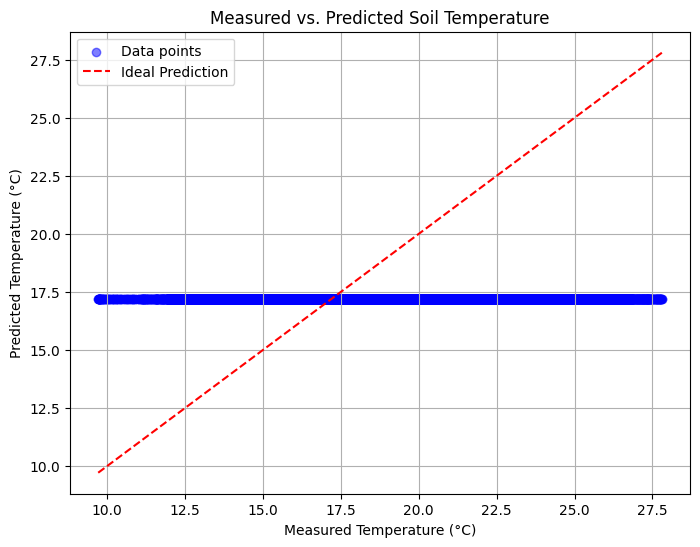

In [47]:
with torch.no_grad():
    T_pred_all = model_test(t_data, z_data, theta_data)
    # Remove extra dimensions and convert to numpy arrays for plotting.
    T_pred_all = T_pred_all.squeeze().cpu().numpy()
    T_measured_all = T_measured_data.squeeze().cpu().numpy()

# Create a scatter plot comparing measured vs. predicted temperatures.
plt.figure(figsize=(8, 6))
plt.scatter(T_measured_all, T_pred_all, color='blue', alpha=0.5, label='Data points')

# Plot a reference line (ideal prediction) where predicted equals measured.
min_T = min(T_measured_all.min(), T_pred_all.min())
max_T = max(T_measured_all.max(), T_pred_all.max())
plt.plot([min_T, max_T], [min_T, max_T], 'r--', label='Ideal Prediction')

plt.xlabel("Measured Temperature (°C)")
plt.ylabel("Predicted Temperature (°C)")
plt.title("Measured vs. Predicted Soil Temperature")
plt.legend()
plt.grid(True)
plt.show()